# DeepGlobe Land Cover Classification with PyTorch

In this notebook, we'll explore how to use PyTorch for land cover classification using a small subset of the DeepGlobe Land Cover dataset. We'll build and train several models:

- An MLP that classifies each pixel individually (flattened images).
- An MLP that classifies each pixel using local crops (24x24 patches).
- A simple CNN for segmentation (fully convolutional, no pooling).
- A demonstration of ResNet-FCN for semantic segmentation.

Let's get started!

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

## Dataset Preparation

For this demonstration, we'll use a small subset of the DeepGlobe Land Cover dataset. The dataset consists of satellite images and corresponding ground truth masks with land cover classes.

**Note:** Ensure that you have the images and masks stored in accessible directories.

In [2]:
import paramiko
from scp import SCPClient
import pandas as pd
import os
import getpass

# SSH and server details
hostname = 'femianjc-gpu.csi.miamioh.edu'
username = getpass.getuser()  # Replace with your SSH username
password = getpass.getpass('Password for femianjc-gpu:')  # Or use SSH keys for passwordless access
remote_metadata_path = '/data/cse620b/deepglobe-landcover/metadata.csv'

# Local destination directories
image_dir = 'local_images'
mask_dir = 'local_masks'

# Create local directories if they don't exist
os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

print("Connecting to the server...")
# Connect to the server via SSH
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname, username=username, password=password)

# Use SFTP to download the file
sftp = ssh.open_sftp()

# Download the metadata.csv file
print("Downloading metadata.csv file... ")
local_metadata = 'metadata.csv'
sftp.get(remote_metadata_path, local_metadata)

# Load the metadata.csv
metadata = pd.read_csv(local_metadata)

# 1. Filter the 'split' column to get only training images
train_metadata = metadata[metadata['split'] == 'train']

# Get a subset of 10 rows
subset_metadata = train_metadata.sample(n=10, random_state=42)

#  Download satellite images and masks via SFTP
remote_base_dir = '/data/cse620b/deepglobe-landcover/'

for index, row in subset_metadata.iterrows():
    # Paths from the CSV are relative, so we need to prepend the base remote directory
    remote_image_path = os.path.join(remote_base_dir, row['sat_image_path'])
    remote_mask_path = os.path.join(remote_base_dir, row['mask_path'])
    
    # Local file paths
    local_image_path = os.path.join(image_dir, os.path.basename(row['sat_image_path']))
    local_mask_path = os.path.join(mask_dir, os.path.basename(row['mask_path']))
    
    # Download the image and mask via SFTP
    print(f'Downloading {remote_image_path} to {local_image_path}')
    sftp.get(remote_image_path, local_image_path)
    print(f'Downloading {remote_mask_path} to {local_mask_path}')
    sftp.get(remote_mask_path, local_mask_path)

# Close the SFTP connection
sftp.close()
ssh.close()

print(f'Copied 10 satellite images and masks to {image_dir} and {mask_dir}')


Connecting to the server...
Copied 10 satellite images and masks to local_images and local_masks


In [3]:
# Get a subset of 2 rows for testing (ensure they are different from training images)
test_metadata = train_metadata.drop(subset_metadata.index).sample(n=2, random_state=123)

# Create test directories if they don't exist
test_image_dir = 'local_test_images'
test_mask_dir = 'local_test_masks'

os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)

print("Connecting to the server...")
# Connect to the server via SSH
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname, username=username, password=password)

# Use SFTP to download the file
sftp = ssh.open_sftp()

# Download the images and masks for testing
for index, row in test_metadata.iterrows():
    # Remote paths
    remote_image_path = os.path.join(remote_base_dir, row['sat_image_path'])
    remote_mask_path = os.path.join(remote_base_dir, row['mask_path'])
    
    # Local paths
    local_image_path = os.path.join(test_image_dir, os.path.basename(row['sat_image_path']))
    local_mask_path = os.path.join(test_mask_dir, os.path.basename(row['mask_path']))
    
    # Download via SFTP
    print(f'Downloading {remote_image_path} to {local_image_path}')
    sftp.get(remote_image_path, local_image_path)
    print(f'Downloading {remote_mask_path} to {local_mask_path}')
    sftp.get(remote_mask_path, local_mask_path)

print(f'Copied 2 satellite images and masks to {test_image_dir} and {test_mask_dir}')


Connecting to the server...
Copied 2 satellite images and masks to local_test_images and local_test_masks


Let's define a custom `Dataset` class to load the images and masks, applying necessary transformations.

In [4]:
import os
import torch
import numpy as np
import rasterio
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings('ignore', message='Dataset has no geotransform')

class DeepGlobeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, crop_size, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = os.listdir(image_dir)
        self.mask_files = os.listdir(mask_dir)
        self.transform = transform
        self.crop_size = crop_size  # (height, width)

        # Ensure that images and masks are aligned
        self.image_files.sort()
        self.mask_files.sort()

        # Define colors for classes
        self.colors = np.array([
            [0, 255, 255],    # urban_land
            [255, 255, 0],    # agriculture_land
            [255, 0, 255],    # rangeland
            [0, 255, 0],      # forest_land
            [0, 0, 255],      # water
            [255, 255, 255],  # barren_land
            [0, 0, 0]         # unknown
        ])

        
        # Create a 3D lookup table
        self.lookup_table = np.zeros((256, 256, 256), dtype=np.uint8) + 6  # Initialize with 'unknown' class index 6

        # Populate the lookup table
        for idx, color in enumerate(self.colors):
            r, g, b = color
            self.lookup_table[r, g, b] = idx

        # Map colors to classes (this was too slow)
        self.color_to_class = { tuple(color): i for i, color in enumerate(self.colors) }

    def __len__(self):
        return len(self.image_files)

    def color_to_class_idx(self, rgb):
        """ Helper function to map RGB to class index """
        return self.color_to_class.get(tuple(rgb), 6)  # Default to 'unknown' class

    def __getitem__(self, idx):
        # Load image and mask paths
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Open image and mask with rasterio
        with rasterio.open(img_path) as img_dataset, rasterio.open(mask_path) as mask_dataset:
            img_width, img_height = img_dataset.width, img_dataset.height

            # Randomly choose the top-left corner for cropping
            top = np.random.randint(0, img_height - self.crop_size[0])
            left = np.random.randint(0, img_width - self.crop_size[1])

            # Define the window for cropping
            window = rasterio.windows.Window(left, top, self.crop_size[1], self.crop_size[0])

            # Read the cropped region from the image and mask
            image = img_dataset.read(window=window)  # (C, H, W) format
            mask = mask_dataset.read(window=window)  # 

        # Convert the image to (H, W, C) for compatibility with transforms
        image = image.transpose(1, 2, 0)  # Convert to (H, W, C) format

        # Apply the color-to-class mapping to the mask
        # mask_class = np.apply_along_axis(self.color_to_class_idx, 0, mask)
        mask_class = self.lookup_table[
                    mask[0],
                    mask[1],
                    mask[2]
                ]

        # Convert image and mask to PyTorch tensors
        mask_class_tensor = torch.from_numpy(mask_class).long()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()  # Convert to (C, H, W)

        if self.transform:
            # Apply the same random transformation to both image and mask
            image_tensor, mask_class_tensor = self.transform(image_tensor, mask_class_tensor)

        return image_tensor, mask_class_tensor


Now, let's create instances of our dataset and data loaders.

In [8]:
# Create the dataset
train_dataset = DeepGlobeDataset(image_dir, mask_dir, crop_size=(512,512))

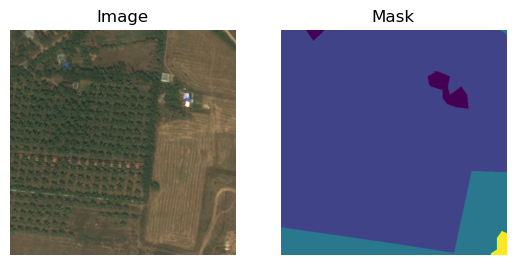

In [7]:
image, mask = train_dataset[0]

plt.subplot(121)
plt.imshow(image.permute(1, 2,0).numpy()/255.)
plt.axis('off')
plt.title('Image')

plt.subplot(122)
plt.imshow(mask)
plt.axis('off')
plt.title('Mask')
plt.show()



## Model 1: MLP that Classifies Each Pixel Individually (Flattened Images)

In this model, we'll flatten the entire image and treat it as a single vector input to an MLP. Each pixel will be classified independently.

In [16]:
# Create the dataset
train_dataset = DeepGlobeDataset(image_dir, mask_dir, crop_size=(1000,1000))
test_dataset = DeepGlobeDataset(test_image_dir, test_mask_dir, crop_size=(1000,1000))


In [17]:
# Create the data loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0) # Always set the number of workers to zero when debugging!
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [11]:
class MLP(nn.Module):
    def __init__(self, num_inputs, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 30)
        self.fc2 = nn.Linear(30,30)
        self.fc3 = nn.Linear(30, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

num_inputs = 3 # number of input features
num_classes = 7  # Number of land cover classes

# Instantiate the model
model1 = MLP(3, num_classes)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} for training")

Using cuda for training


In [13]:
model1 = model1.to(device)

Define loss function and optimizer.

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)  # IMportant model is on the right device when accessing its parameters

**Training Loop for Model 1**

In [18]:
num_epochs = 5
import tqdm.auto as tq

for epoch in tq.trange(num_epochs):
    model1.train()
    running_loss = 0.0
    for images, masks in tq.tqdm(train_loader):
        images= images.to(device) # Move images to the same device as the model
        masks = masks.to(device)  # Move masks to the same device as the model

        # Flatten images
        images = images.view(-1, 3)  # Flatten the entire minibatch
        # Flatten masks
        masks = masks.view(-1)

        # Forward pass
        outputs = model1(images)
        # Since outputs are of shape (batch_size, num_classes), need to adjust masks
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x773974137e20>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/cse620b-shared/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/envs/cse620b-shared/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda3/envs/cse620b-shared/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/cse620b-shared/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/cse620b-shared/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^

Epoch [1/5], Loss: 1.3187


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/5], Loss: 1.5082


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3/5], Loss: 1.6306


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4/5], Loss: 1.4988


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/5], Loss: 1.4194


In [121]:
def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():  # Disable gradient computation
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Flatten images and masks just like in training
            images = images.view(-1, 3)
            masks = masks.view(-1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Accumulate loss
            running_loss += loss.item()

            # Predictions and accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == masks).sum().item()
            total_pixels += masks.size(0)

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * total_correct / total_pixels
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [122]:
evaluate(model1, test_loader, criterion)

Validation Loss: 1.5087, Accuracy: 26.25%


(1.5087146759033203, 26.2487)

## Model 2: MLP that Classifies Each Pixel Using 24x24 Crops

In this model, we'll use local patches (crops) of the image to classify each pixel, allowing the model to consider local context.

**Note:** Due to time constraints and the complexity of sourcing an optimal dataset for this demonstration, the code below has not been fully debugged or tested prior to class. Please consider this as a foundational framework that we'll refine and troubleshoot together during our session.


In [ ]:
class MLPCrops(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPCrops, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Input size remains the same
model2 = MLPCrops(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

**Training Loop for Model 2**

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    for images, masks in train_loader:
        # Flatten images
        images = images.view(images.size(0), -1)
        # For masks, we can use the center pixel as the target
        center_pixel = masks[:, crop_size[0]//2, crop_size[1]//2]

        # Forward pass
        outputs = model2(images)
        # outputs shape: (batch_size, num_classes)

        loss = criterion(outputs, center_pixel)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

**Note:** This model uses local context around each pixel but still outputs a single class per crop.

## Model 3: Simple CNN for Segmentation (Fully Convolutional, No Pooling)

Now we'll build a simple CNN that performs pixel-wise classification over the entire image.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        # x shape: (batch_size, 3, height, width)
        x = torch.relu(self.conv1(x))
        x = self.conv2(x)
        return x  # Output shape: (batch_size, num_classes, height, width)

# Instantiate the model
model3 = SimpleCNN(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

**Training Loop for Model 3**

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model3.train()
    running_loss = 0.0
    for images, masks in train_loader:
        # Forward pass
        outputs = model3(images)
        # outputs shape: (batch_size, num_classes, height, width)
        # masks shape: (batch_size, height, width)

        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

**Note:** This CNN preserves spatial dimensions and outputs a class prediction for each pixel.

## Model 4: ResNet-FCN for Semantic Segmentation

Finally, we'll use a pre-trained ResNet model with a Fully Convolutional Network (FCN) head for segmentation.

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

# Load a pre-trained FCN model
model4 = fcn_resnet50(pretrained=True)

# Adjust the classifier to output num_classes
model4.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.0001)

**Training Loop for Model 4**

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model4.train()
    running_loss = 0.0
    for images, masks in train_loader:
        # Forward pass
        outputs = model4(images)['out']
        # outputs shape: (batch_size, num_classes, height, width)
        # masks shape: (batch_size, height, width)

        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

**Explanation:**

- **ResNet-FCN**: Combines a ResNet backbone for feature extraction with an FCN head for pixel-wise classification.
- **Transfer Learning**: We use a pre-trained model to leverage learned features and adjust the final layer to our number of classes.
- **Advantages**: More powerful than previous models, capable of capturing complex patterns in the data.

## Visualization of Results

Let's visualize some predictions from our models.

In [ ]:
def visualize_predictions(model, dataset, index=0):
    model.eval()
    image, mask = dataset[index]
    image = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        if isinstance(output, dict):
            output = output['out']
        preds = torch.argmax(output, dim=1).squeeze(0)

    # Convert tensors to numpy arrays for plotting
    image_np = image.squeeze(0).permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    preds_np = preds.numpy()

    # Plotting
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('Input Image')
    plt.imshow(image_np)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title('Ground Truth')
    plt.imshow(mask_np, cmap='jet')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title('Predicted Mask')
    plt.imshow(preds_np, cmap='jet')
    plt.axis('off')

    plt.show()

In [ ]:
# Visualize predictions from Model 3 (SimpleCNN)
visualize_predictions(model3, train_dataset)

**Note:** You can replace `model3` with `model4` to visualize predictions from the ResNet-FCN model.

## Conclusion

In this notebook, we explored different approaches to land cover classification using PyTorch:

- **MLP with Flattened Images**: Simple but loses spatial information.
- **MLP with Crops**: Considers local context but limited in capturing complex spatial patterns.
- **Simple CNN**: Preserves spatial information and allows for pixel-wise classification.
- **ResNet-FCN**: Advanced model leveraging transfer learning for better performance.

This demonstrates how different architectures can be applied to the task of semantic segmentation in remote sensing.